# Imports and Data Handling

In [8]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import src as tools
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE
#import seaborn as sns

In [9]:
np.random.seed(0)

In [10]:
df = pd.read_csv("fetal_health.csv")

#As discussed in the project proposal, we will experiment with using only the first 7 features that are actual recordings of
#the patients monitoring.
short_df = df[['baseline value','accelerations','fetal_movement','uterine_contractions'
               ,'light_decelerations','severe_decelerations','prolongued_decelerations']]

y_labels = df[['fetal_health']]

df = df.loc[:,df.columns!="fetal_health"]

df = df.to_numpy()
short_df = short_df.to_numpy()
y_labels = y_labels.to_numpy()
y_labels = y_labels-1

print("Original dataset:",df.shape[0],"datapoints,",df.shape[1],"features")
print("Shortened Dataset:",short_df.shape[0],"datapoints,",short_df.shape[1],"features")
print("True labels of Dataset:",y_labels.shape)
#Thankfully all the values are numerical, no need to reencode them

Original dataset: 2126 datapoints, 21 features
Shortened Dataset: 2126 datapoints, 7 features
True labels of Dataset: (2126, 1)


# KNN(small dataset & no cross validation)

Training Set size: (1700, 7)
Training Target size (1700, 1)
Testing Set size: (426, 7)


10
20
30
40
50
60
70
80
90
100


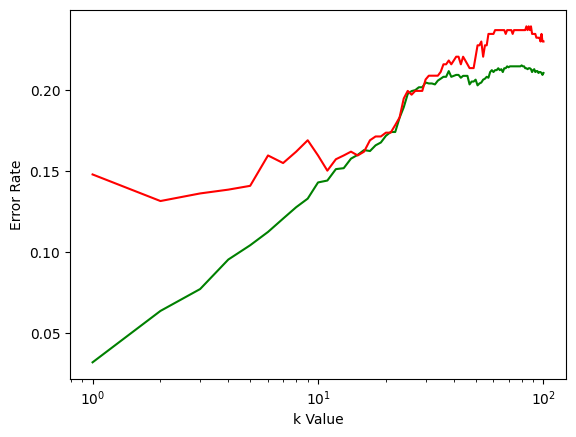

Lowest error rate is 0.13145539906103287 at k = 2
Accuracy: 0.8685446009389671
F1 Score: 0.8611733644288079


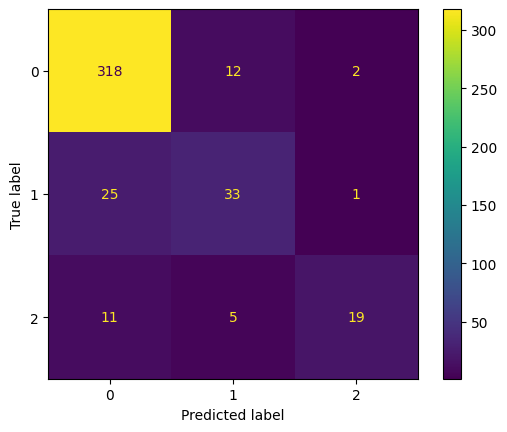

In [11]:
#With the dataset prepared, we will start the fist KNN model. It will be trained using the small dataset with no cross
#validation.
x_train, x_test, y_train, y_test = train_test_split(short_df, y_labels, test_size=0.2,stratify=y_labels)
print("Training Set size:",x_train.shape)
print("Training Target size", y_train.shape)
print("Testing Set size:",x_test.shape)

KNN_testErrors = [] #index will represent k value. Testing up to k = 100
KNN_trainErrors = []

for k in range(100):
    k = k+1 #1-100, not 0-99
    if(k%10==0):
        print(k) #Scuffed progress bar
    knnClassifier = KNeighborsClassifier(n_neighbors=k)
    knnClassifier.fit(x_train, y_train.ravel())
    
    y_train_pred = knnClassifier.predict(x_train)
    y_test_pred = knnClassifier.predict(x_test)
    
    train_accuracy = accuracy_score(y_train,y_train_pred)
    test_accuracy = accuracy_score(y_test,y_test_pred)
    train_error = 1-train_accuracy
    test_error = 1-test_accuracy
    KNN_trainErrors.append(train_error)
    KNN_testErrors.append(test_error)
    
plt.semilogx(range(1, len(KNN_trainErrors) + 1), KNN_trainErrors, color='g')
plt.semilogx(range(1, len(KNN_testErrors) + 1), KNN_testErrors, color='r')
plt.xlabel('k Value')
plt.ylabel('Error Rate')
plt.show()

bestk = KNN_testErrors.index(min(KNN_testErrors))+1
print("Lowest error rate is",min(KNN_testErrors),"at k =",bestk)

knnClassifier = KNeighborsClassifier(n_neighbors=bestk)
knnClassifier.fit(x_train, y_train.ravel())
y_test_pred = knnClassifier.predict(x_test)

matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
print("Accuracy: {}".format(accuracy_score(y_test,y_test_pred)))
print("F1 Score: {}".format(f1_score(y_test, y_test_pred, average="weighted")))

# KNN(small dataset & cross validation)

10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


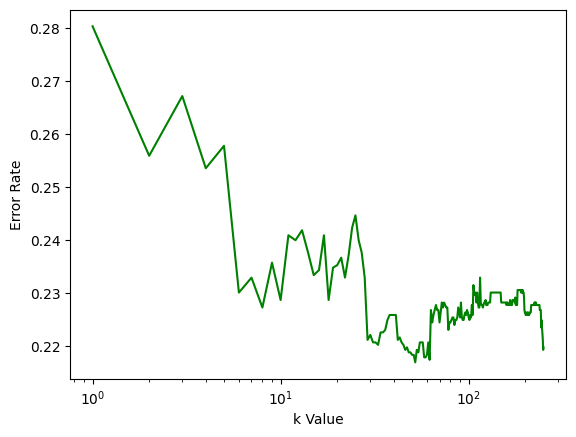

Lowest error rate is 0.21693123446561727 at k = 52
Training Set size: (1700, 7)
Training Targt size (1700, 1)
Testing Set size: (426, 7)
Accuracy score: 0.7863849765258216
F1 score: 0.7175491936055317


c:\Users\jeffr\Desktop\CS184A\Project\FetusHealthML\Project\venv\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


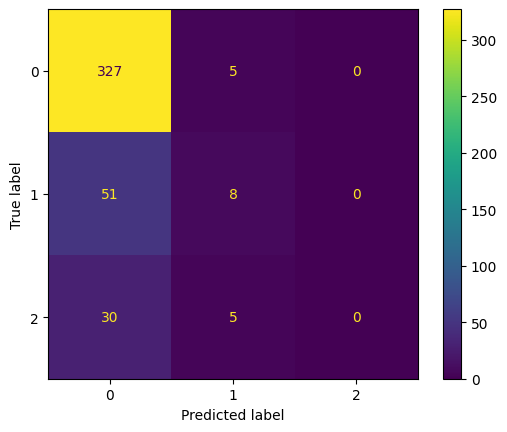

In [12]:
#Using the KNNClassifier from the sklearnknn_classifier.fit(X_train, y_train) library, we will experiment with different values of k.

KNN_crossValidationErrors = [0]*250

for k in range(250):
    k = k+1 #1-250 not 0-249
    if(k%25==0):
        print(k/2.5) #Scuffed progress bar
    # Cross-validation with 5 fold
    nFolds = 5
    for iFold in range(nFolds):
        Xti, Xvi, Yti, Yvi = tools.crossValidate(short_df, y_labels,nFolds, iFold)
        knnClassifier = KNeighborsClassifier(n_neighbors=k)
        knnClassifier.fit(Xti, Yti)
    
        cross_validation_pred = knnClassifier.predict(Xvi)
    
        cross_validation_accuracy = accuracy_score(Yvi,cross_validation_pred)

        cross_validation_error = 1-cross_validation_accuracy
        KNN_crossValidationErrors[k-1] += cross_validation_error
    KNN_crossValidationErrors[k-1] = KNN_crossValidationErrors[k-1]/nFolds

plt.semilogx(range(1, len(KNN_crossValidationErrors) + 1), KNN_crossValidationErrors, color='g')
plt.xlabel('k Value')
plt.ylabel('Error Rate')
plt.show()

print("Lowest error rate is",min(KNN_crossValidationErrors),"at k =",KNN_crossValidationErrors.index(min(KNN_crossValidationErrors))+1)
# k = KNN_testErrors.index(min(KNN_testErrors))+1 because it's pulling the error rate from a list (starts at 0)
#But k values actually start at k = 1
bestk = KNN_crossValidationErrors.index(min(KNN_crossValidationErrors))+1


#Confusion Matrix for best performing KNN.
x_train, x_test, y_train, y_test = train_test_split(short_df, y_labels, test_size=0.2,stratify=y_labels)
print("Training Set size:",x_train.shape)
print("Training Targt size", y_train.shape)
print("Testing Set size:",x_test.shape)

knnClassifier = KNeighborsClassifier(n_neighbors=bestk)
knnClassifier.fit(x_train, y_train)
y_test_pred = knnClassifier.predict(x_test)
matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
print("Accuracy score: {}".format(accuracy_score(y_test,y_test_pred)))
print("F1 score: {}".format(f1_score(y_test, y_test_pred,average="weighted")))

# KNN(normal dataset & NO cross validation)

Training Set size: (1700, 21)
Testing Set size: (426, 21)
10
20
30
40
50
60
70
80
90
100


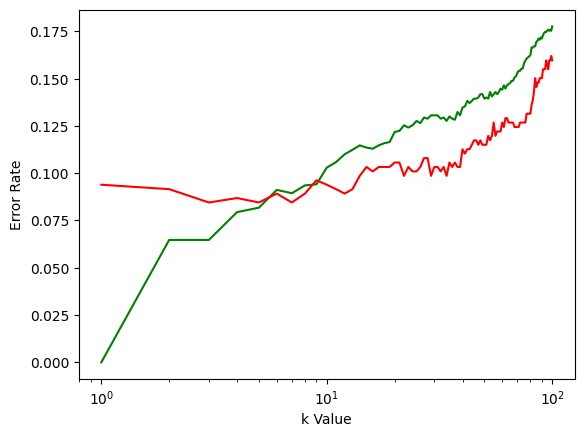

Lowest error rate is 0.08450704225352113 at k = 3
Accuracy: 0.9154929577464789
F1 Score: 0.9138825431980803


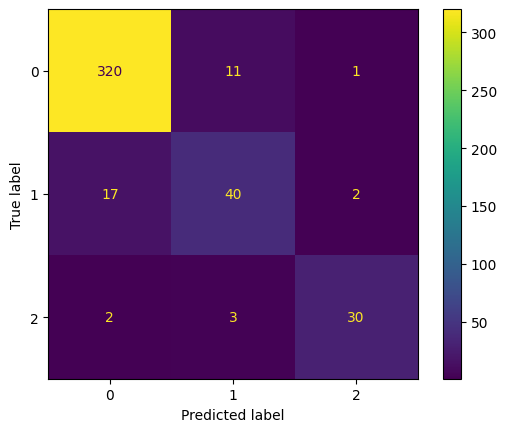

In [13]:
#We will repeat the same process, but with the entire dataset. To save time, I will only test for up to k=100. 
#In all likelihood, the best k value will reveal itself early on
x_train2, x_test2, y_train2, y_test2 = train_test_split(df, y_labels, test_size=0.2,stratify=y_labels)
print("Training Set size:",x_train2.shape)
print("Testing Set size:",x_test2.shape)

KNN_testErrors = [] #index will represent k value. Testing up to k = 100
KNN_trainErrors = []
for k in range(100):
    k = k+1 #1-100, not 0-99
    if(k%10==0):
        print(k) #Scuffed progress bar
    knnClassifier = KNeighborsClassifier(n_neighbors=k)
    knnClassifier.fit(x_train2, y_train2.ravel())
    
    y_train_pred2 = knnClassifier.predict(x_train2)
    y_test_pred2 = knnClassifier.predict(x_test2)
    
    train_accuracy2 = accuracy_score(y_train2,y_train_pred2)
    test_accuracy2 = accuracy_score(y_test2,y_test_pred2)
    train_error2 = 1-train_accuracy2
    test_error2 = 1-test_accuracy2
    KNN_trainErrors.append(train_error2)
    KNN_testErrors.append(test_error2)
    
plt.semilogx(range(1, len(KNN_trainErrors) + 1), KNN_trainErrors, color='g')
plt.semilogx(range(1, len(KNN_testErrors) + 1), KNN_testErrors, color='r')
plt.xlabel('k Value')
plt.ylabel('Error Rate')
plt.show()

bestk = KNN_testErrors.index(min(KNN_testErrors))+1
print("Lowest error rate is",min(KNN_testErrors),"at k =",bestk)

knnClassifier = KNeighborsClassifier(n_neighbors=bestk)
knnClassifier.fit(x_train2, y_train2.ravel())
y_test_pred2 = knnClassifier.predict(x_test2)

matrix = confusion_matrix(y_test2, y_test_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
print("Accuracy: {}".format(accuracy_score(y_test2,y_test_pred2)))
print("F1 Score: {}".format(f1_score(y_test2, y_test_pred2, average="weighted")))

# KNN(normal dataset & cross validation)

Training Set size: (2126, 21)
Training Labels size:
10
20
30
40
50
60
70
80
90
100


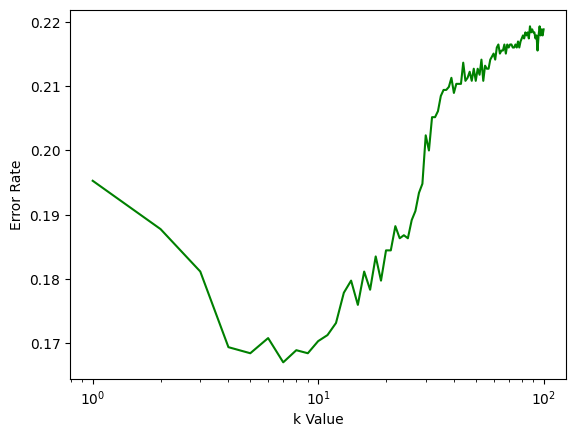

Lowest cross-validation error rate is 0.16705109085887876 at k = 7
Accuracy: 0.892018779342723
F1 Score: 0.8869830418508452


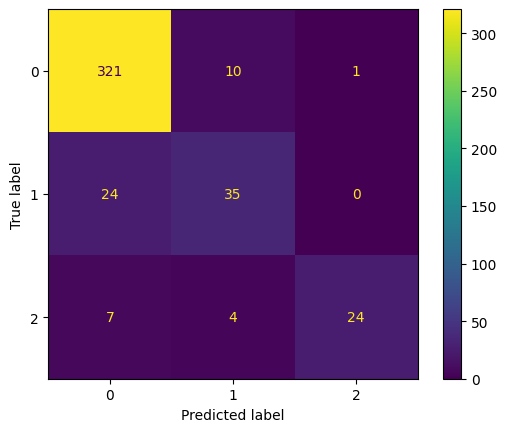

In [14]:
#We will repeat the same process, but with the entire dataset. To save time, I will only test for up to k=100. 
#In all likelihood, the best k value will reveal itself early on
x_train2 = df
y_train2 = y_labels
print("Training Set size:",x_train2.shape)
print("Training Labels size:",)

x_train2 = np.array(x_train2)
y_train2 = np.array(y_train2)

KNN_testErrors = [0]*100 #index will represent k value. Testing up to k = 100
KNN_trainErrors = [0]*100
for k in range(100):
    k = k+1 #1-100, not 0-99
    if(k%10==0):
        print(k) #Scuffed progress bar
    nFolds = 5
    for iFold in range(nFolds):
        Xti, Xvi, Yti, Yvi = tools.crossValidate(x_train2, y_train2,nFolds, iFold)
        knnClassifier = KNeighborsClassifier(n_neighbors=k)
        knnClassifier.fit(Xti, Yti)
    
        y_train_pred2 = knnClassifier.predict(Xvi)
    
        train_accuracy2 = accuracy_score(Yvi,y_train_pred2)
        train_error2 = 1-train_accuracy2
        KNN_trainErrors[k-1] += train_error2
    KNN_trainErrors[k-1] = KNN_trainErrors[k-1]/5
    
plt.semilogx(range(1, len(KNN_trainErrors) + 1), KNN_trainErrors, color='g')
plt.xlabel('k Value')
plt.ylabel('Error Rate')
plt.show()

bestk = KNN_trainErrors.index(min(KNN_trainErrors))+1
print("Lowest cross-validation error rate is",min(KNN_trainErrors),"at k =",bestk)

x_train2, x_test2, y_train2, y_test2 = train_test_split(df, y_labels, test_size=0.2,stratify=y_labels)
knnClassifier = KNeighborsClassifier(n_neighbors=bestk)
knnClassifier.fit(x_train2, y_train2.ravel())
y_test_pred2 = knnClassifier.predict(x_test2)
matrix = confusion_matrix(y_test2, y_test_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
print("Accuracy: {}".format(accuracy_score(y_test2,y_test_pred2)))
print("F1 Score: {}".format(f1_score(y_test2, y_test_pred2, average="weighted")))

Overall, KNN had some decent predicting power. As expected, as more features became considered, KNN's prediction accuracy on testing sets declined significantly. 

## MLP 

In [15]:
#We'll start with a simple one
model = keras.Sequential(name="FetusHealthNNmodel1")
model.add(layers.Dense(150, activation='relu',input_dim=7))
model.add(layers.Dense(75, activation='relu'))
model.add(layers.Dense(3,activation='softmax'))

In [16]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model.summary())


Model: "FetusHealthNNmodel1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               1200      
                                                                 
 dense_1 (Dense)             (None, 75)                11325     
                                                                 
 dense_2 (Dense)             (None, 3)                 228       
                                                                 
Total params: 12753 (49.82 KB)
Trainable params: 12753 (49.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [17]:
nFolds = 5
testingCrossValidationError = []
f1scoreAvg = []
for iFold in range(nFolds):
    Xti, Xvi, Yti, Yvi = tools.crossValidate(short_df, y_labels,nFolds, iFold)
    model.fit(Xti, Yti, epochs=5)
    y_test_pred = np.argmax(model.predict(Xvi),axis=1) #to get the prediction based off of the softmax results
   #print(y_test_pred)
    test_accuracy = accuracy_score(Yvi,y_test_pred)
    testingCrossValidationError.append(test_accuracy)
    f1scoreAvg.append(f1_score(Yvi, y_test_pred,average="weighted"))

Epoch 1/5


54/54 [==============================] - 1s 944us/step - loss: 0.7891 - accuracy: 0.8007
Epoch 2/5
54/54 [==============================] - 0s 830us/step - loss: 0.6542 - accuracy: 0.8289
Epoch 3/5
54/54 [==============================] - 0s 849us/step - loss: 0.6339 - accuracy: 0.8289
Epoch 4/5
54/54 [==============================] - 0s 793us/step - loss: 0.6271 - accuracy: 0.8289
Epoch 5/5
14/14 [==============================] - 0s 846us/step
Epoch 1/5
54/54 [==============================] - 0s 830us/step - loss: 0.7194 - accuracy: 0.7937
Epoch 2/5
54/54 [==============================] - 0s 868us/step - loss: 0.6622 - accuracy: 0.8089
Epoch 3/5
54/54 [==============================] - 0s 793us/step - loss: 0.6861 - accuracy: 0.8089
Epoch 4/5
54/54 [==============================] - 0s 830us/step - loss: 0.6757 - accuracy: 0.8089
Epoch 5/5
14/14 [==============================] - 0s 769us/step
Epoch 1/5
54/54 [==============================] - 0s 839us/step - loss: 0.8

In [18]:
#Metrics for short_df NN with cross validation
avgTestAccuracy = sum(testingCrossValidationError)/nFolds
print("Testing Accuracy:",avgTestAccuracy)
print("F1 Score Avg:",sum(f1scoreAvg)/nFolds)

Testing Accuracy: 0.7783628831814415
F1 Score Avg: 0.6890827026956996


Epoch 1/5
54/54 [==============================] - 0s 830us/step - loss: 0.9367 - accuracy: 0.7688
Epoch 2/5
54/54 [==============================] - 0s 812us/step - loss: 0.7804 - accuracy: 0.7647
Epoch 3/5
54/54 [==============================] - 0s 822us/step - loss: 0.8301 - accuracy: 0.7400
Epoch 4/5
54/54 [==============================] - 0s 787us/step - loss: 0.7401 - accuracy: 0.7782
Epoch 5/5
14/14 [==============================] - 0s 769us/step


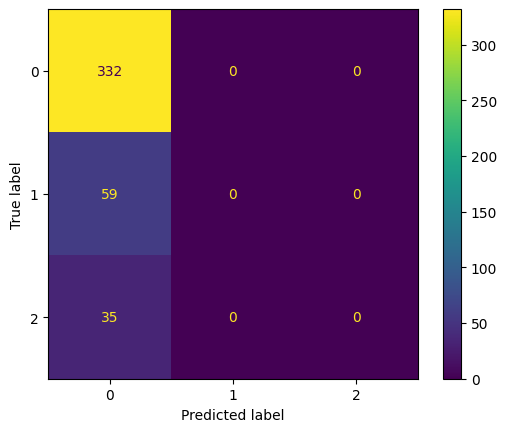

In [19]:
#Conf Matrix for short_df NN (for some reason, it requires me to create model from scratch again)
#When the model has the short dataset, it will only guess 0...
model = keras.Sequential(name="FetusHealthNNmodel1")
model.add(layers.Dense(150, activation='relu',input_dim=7))
model.add(layers.Dense(75, activation='relu'))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
x_train, x_test, y_train, y_test = train_test_split(short_df, y_labels, test_size=0.2,stratify=y_labels)
model.fit(x_train,y_train,epochs=5)
y_pred = np.argmax(model.predict(x_test),axis=1)
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

In [20]:
#Repeating same NN model but with the whole dataset
model = keras.Sequential(name="FetusHealthNNmodel2")
model.add(layers.Dense(150, activation='relu',input_dim=21))
model.add(layers.Dense(75, activation='relu'))
model.add(layers.Dense(3,activation='softmax'))

In [21]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "FetusHealthNNmodel2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 150)               3300      
                                                                 
 dense_7 (Dense)             (None, 75)                11325     
                                                                 
 dense_8 (Dense)             (None, 3)                 228       
                                                                 
Total params: 14853 (58.02 KB)
Trainable params: 14853 (58.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [22]:
nFolds = 5
testingCrossValidationError = []
f1scoreAvg=[]
for iFold in range(nFolds):
    Xti, Xvi, Yti, Yvi = tools.crossValidate(df, y_labels,nFolds, iFold)
    model.fit(Xti, Yti, epochs=5)
    y_test_pred = np.argmax(model.predict(Xvi),axis=1) #to get the prediction based off of the softmax results
    #print(y_test_pred)
    test_accuracy = accuracy_score(Yvi,y_test_pred)
    testingCrossValidationError.append(test_accuracy)
    f1scoreAvg.append(f1_score(Yvi, y_test_pred,average="weighted"))

Epoch 1/5
54/54 [==============================] - 0s 868us/step - loss: 4.4859 - accuracy: 0.7760
Epoch 2/5
54/54 [==============================] - 0s 774us/step - loss: 0.8539 - accuracy: 0.8342
Epoch 3/5
54/54 [==============================] - 0s 801us/step - loss: 0.5556 - accuracy: 0.8595
Epoch 4/5
54/54 [==============================] - 0s 821us/step - loss: 0.4573 - accuracy: 0.8624
Epoch 5/5
14/14 [==============================] - 0s 692us/step
Epoch 1/5
54/54 [==============================] - 0s 830us/step - loss: 0.6448 - accuracy: 0.8354
Epoch 2/5
54/54 [==============================] - 0s 811us/step - loss: 0.4097 - accuracy: 0.8618
Epoch 3/5
54/54 [==============================] - 0s 781us/step - loss: 0.4462 - accuracy: 0.8601
Epoch 4/5
54/54 [==============================] - 0s 811us/step - loss: 0.5292 - accuracy: 0.8460
Epoch 5/5
14/14 [==============================] - 0s 769us/step
Epoch 1/5
54/54 [==============================] - 0s 831us/step - loss: 0.817

In [23]:
avgTestAccuracy = sum(testingCrossValidationError)/nFolds
print("Testing Accuracy:",avgTestAccuracy)
print("F1 Score Avg:",sum(f1scoreAvg)/nFolds)

Testing Accuracy: 0.6282220381110191
F1 Score Avg: 0.5788117067526983


Epoch 1/5
54/54 [==============================] - 0s 880us/step - loss: 2.0095 - accuracy: 0.7782
Epoch 2/5
54/54 [==============================] - 0s 811us/step - loss: 0.5899 - accuracy: 0.8224
Epoch 3/5
54/54 [==============================] - 0s 793us/step - loss: 0.5984 - accuracy: 0.8306
Epoch 4/5
54/54 [==============================] - 0s 1ms/step - loss: 0.4836 - accuracy: 0.8465
Epoch 5/5
14/14 [==============================] - 0s 692us/step


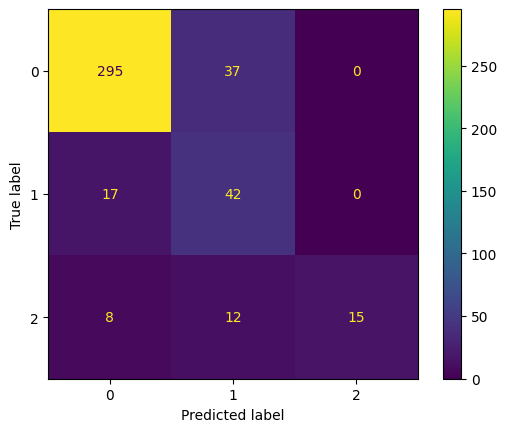

In [24]:
#Conf Matrix for df NN
model = keras.Sequential(name="FetusHealthNNmodel1")
model.add(layers.Dense(150, activation='relu',input_dim=21))
model.add(layers.Dense(75, activation='relu'))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
x_train, x_test, y_train, y_test = train_test_split(df, y_labels, test_size=0.2,stratify=y_labels)
model.fit(x_train,y_train,epochs=5)
y_pred = np.argmax(model.predict(x_test),axis=1)
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

In [25]:
# The models are performing poorly most likely because the data set is heavily imbalanced towards the 0 class compared 
#to 1 and 2. To address this, the model will be trained with class weights. Entire dataset is still used.

#EDIT: THE MODELS KEPT GUESSING ONE LABEL BECAUSE OF SGD OPTIMIZER. ONCE MODIFIED TO ADAM OPTIMIZER, IT STARTED PERFORMING
#BETTER. APPROXIMATELY 88 PERCENT ACCURACY.
unique, counts = np.unique(y_labels, return_counts=True)
class_weights = dict(zip(unique, counts))
#print(class_weights)
#class weights created using inverse class frequency method
class_weights[0] = y_labels.size/(3*class_weights[0])
class_weights[1] =  y_labels.size/(3*class_weights[1])
class_weights[2] =  y_labels.size/(3*class_weights[2])
print(class_weights)


{0.0: 0.4281973816717019, 1.0: 2.4022598870056497, 2.0: 4.026515151515151}


In [26]:
#With the weights, we can recompile the model, and hopefully obtain better results.
#Repeating same NN model but with the whole dataset
model = keras.Sequential(name="FetusHealthNNmodel_class_weights")
model.add(layers.Dense(150, activation='relu',input_dim=21))
model.add(layers.Dense(75, activation='relu'))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "FetusHealthNNmodel_class_weights"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 150)               3300      


                                                                 
 dense_13 (Dense)            (None, 75)                11325     
                                                                 
 dense_14 (Dense)            (None, 3)                 228       
                                                                 
Total params: 14853 (58.02 KB)
Trainable params: 14853 (58.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [27]:
nFolds = 5
testingCrossValidationError = []
f1scoreAvg=[]
for iFold in range(nFolds):
    Xti, Xvi, Yti, Yvi = tools.crossValidate(df, y_labels,nFolds, iFold)
    model.fit(Xti, Yti, epochs=5,class_weight=class_weights)
    y_test_pred = np.argmax(model.predict(Xvi),axis=1) #to get the prediction based off of the softmax results
    #print(y_test_pred)
    test_accuracy = accuracy_score(Yvi,y_test_pred)
    testingCrossValidationError.append(test_accuracy)
    f1scoreAvg.append(f1_score(Yvi, y_test_pred,average="weighted"))

Epoch 1/5
54/54 [==============================] - 0s 887us/step - loss: 2.7699 - accuracy: 0.6279
Epoch 2/5
54/54 [==============================] - 0s 878us/step - loss: 1.3862 - accuracy: 0.7096
Epoch 3/5
54/54 [==============================] - 0s 900us/step - loss: 1.1814 - accuracy: 0.7249
Epoch 4/5
54/54 [==============================] - 0s 844us/step - loss: 0.7600 - accuracy: 0.7737
Epoch 5/5
14/14 [==============================] - 0s 769us/step
Epoch 1/5
54/54 [==============================] - 0s 889us/step - loss: 1.0641 - accuracy: 0.7366
Epoch 2/5
54/54 [==============================] - 0s 804us/step - loss: 0.7938 - accuracy: 0.7425
Epoch 3/5
54/54 [==============================] - 0s 859us/step - loss: 0.7280 - accuracy: 0.7748
Epoch 4/5
54/54 [==============================] - 0s 906us/step - loss: 0.8292 - accuracy: 0.7255
Epoch 5/5
14/14 [==============================] - 0s 769us/step
Epoch 1/5
54/54 [==============================] - 0s 856us/step - loss: 0.894

In [28]:
avgTestAccuracy = sum(testingCrossValidationError)/nFolds
print("Testing Accuracy:",avgTestAccuracy)
print("F1 Score Avg:",sum(f1scoreAvg)/nFolds)

Testing Accuracy: 0.6848417564208782
F1 Score Avg: 0.7095054834254375


Epoch 1/5
54/54 [==============================] - 0s 906us/step - loss: 3.1557 - accuracy: 0.5996
Epoch 2/5
54/54 [==============================] - 0s 832us/step - loss: 1.2298 - accuracy: 0.6772
Epoch 3/5
54/54 [==============================] - 0s 850us/step - loss: 0.9786 - accuracy: 0.7255
Epoch 4/5
54/54 [==============================] - 0s 842us/step - loss: 0.8880 - accuracy: 0.7466
Epoch 5/5
14/14 [==============================] - 0s 771us/step


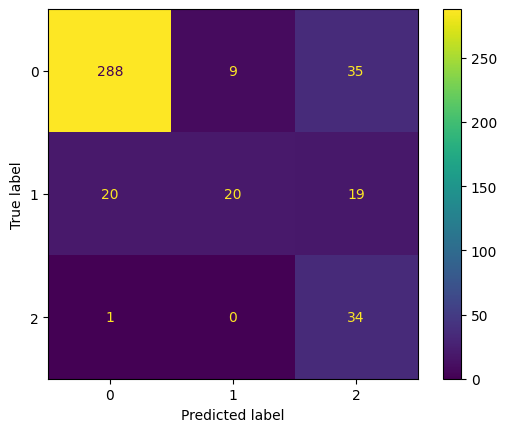

In [29]:
model = keras.Sequential(name="FetusHealthNNmodel_class_weights")
model.add(layers.Dense(150, activation='relu',input_dim=21))
model.add(layers.Dense(75, activation='relu'))
model.add(layers.Dense(3,activation='softmax'))
x_train, x_test, y_train, y_test = train_test_split(df, y_labels, test_size=0.2,stratify=y_labels)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(Xti, Yti, epochs=5,class_weight=class_weights)
y_pred = np.argmax(model.predict(x_test),axis=1)
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

In [30]:
#Unfortuantely, class weights didn't seem to improve the accuracy at all.
#Instead of informing the model of class weights, we will be using SMOTE (Synthetic Minority Oversampling Technique) to
#forcefully balance the dataset. Hopefully, this will yield more promising results...
#After the data is split for a fold, I'll use imblearn's SMOTE algorithm to create a more balanced dataset.
#This introduces another variable (how we choose to balance our dataset) 
#With the weights, we can recompile the model, and hopefully obtain better results.
#Repeating same NN model but with the whole dataset
model = keras.Sequential(name="FetusHealthNNmodel_Rebalanced")
model.add(layers.Dense(150, activation='relu',input_dim=21))
model.add(layers.Dense(75, activation='relu'))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "FetusHealthNNmodel_Rebalanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 150)               3300      
                                                                 
 dense_19 (Dense)            (None, 75)                11325     
                                                                 
 dense_20 (Dense)            (None, 3)                 228       
                                                                 
Total params: 14853 (58.02 KB)
Trainable params: 14853 (58.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [31]:
nFolds = 5
testingCrossValidationError = []
f1scoreAvg=[]
smoteMachine = SMOTE(random_state=42,k_neighbors=7)
for iFold in range(nFolds):
    Xti, Xvi, Yti, Yvi = tools.crossValidate(df, y_labels,nFolds, iFold)
    #After creating the split for this fold, we must rebalance this dataset
    XtiResample, YtiResample = smoteMachine.fit_resample(Xti, Yti)
    model.fit(XtiResample, YtiResample, epochs=5)
    y_test_pred = np.argmax(model.predict(Xvi),axis=1) #to get the prediction based off of the softmax results
    print(y_test_pred)
    test_accuracy = accuracy_score(Yvi,y_test_pred)
    testingCrossValidationError.append(test_accuracy)
    f1scoreAvg.append(f1_score(Yvi, y_test_pred,average="weighted"))

Epoch 1/5
133/133 [==============================] - 1s 811us/step - loss: 2.4016 - accuracy: 0.6872
Epoch 2/5
133/133 [==============================] - 0s 840us/step - loss: 0.5924 - accuracy: 0.7778
Epoch 3/5
133/133 [==============================] - 0s 841us/step - loss: 0.4697 - accuracy: 0.8158
Epoch 4/5
133/133 [==============================] - 0s 811us/step - loss: 0.4483 - accuracy: 0.8281
Epoch 5/5
14/14 [==============================] - 0s 692us/step
[1 0 0 0 0 2 2 2 2 2 1 1 0 0 0 0 0 0 0 0 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1
 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 2 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0

In [32]:
avgTestAccuracy = sum(testingCrossValidationError)/nFolds
print("Testing Accuracy:",avgTestAccuracy)
print("F1 Score Avg:",sum(f1scoreAvg)/nFolds)

Testing Accuracy: 0.8084805302402651
F1 Score Avg: 0.822784909456837


Epoch 1/5
125/125 [==============================] - 0s 801us/step - loss: 1.3422 - accuracy: 0.7201
Epoch 2/5
125/125 [==============================] - 0s 800us/step - loss: 0.5878 - accuracy: 0.7984
Epoch 3/5
125/125 [==============================] - 0s 818us/step - loss: 0.5617 - accuracy: 0.7992
Epoch 4/5
125/125 [==============================] - 0s 801us/step - loss: 0.6591 - accuracy: 0.7884
Epoch 5/5
14/14 [==============================] - 0s 693us/step


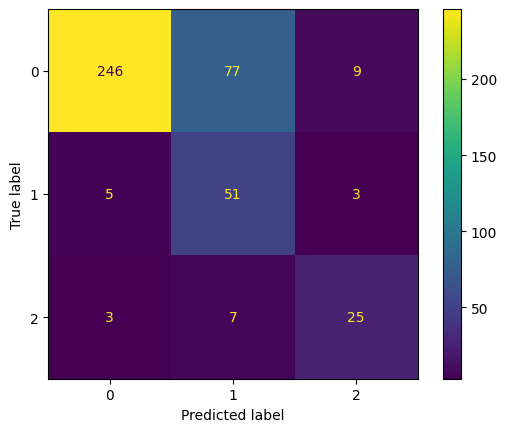

In [33]:
model = keras.Sequential(name="FetusHealthNNmodel_Rebalanced")
model.add(layers.Dense(150, activation='relu',input_dim=21))
model.add(layers.Dense(75, activation='relu'))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
x_train, x_test, y_train, y_test = train_test_split(df, y_labels, test_size=0.2,stratify=y_labels)
XtrainResample, YtrainResample = smoteMachine.fit_resample(x_train, y_train)
model.fit(XtrainResample, YtrainResample, epochs=5)
y_pred = np.argmax(model.predict(x_test),axis=1)
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()